Random Forest algorithm for Machine Failure estimation

In [2]:
import pandas as pd

df = pd.read_csv('Data/workdata.csv')
df = df.iloc[:, 2:-5]  # Disregard the first two and the last five columns which are noise
#df = df.iloc[:,6]
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,L,298.9,309.1,2861,4.6,143,1
1,L,298.9,309.0,1410,65.7,191,1
2,L,298.8,308.9,1455,41.3,208,1
3,L,298.4,308.2,1282,60.7,216,1
4,L,298.3,308.1,1412,52.3,218,1


In [3]:
df['Machine failure'].value_counts()

Machine failure
0    700
1    339
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

x = df.drop(['Type','Machine failure'], axis=1) # Disregard the machine failure column
y = df['Machine failure']  # The target variable

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

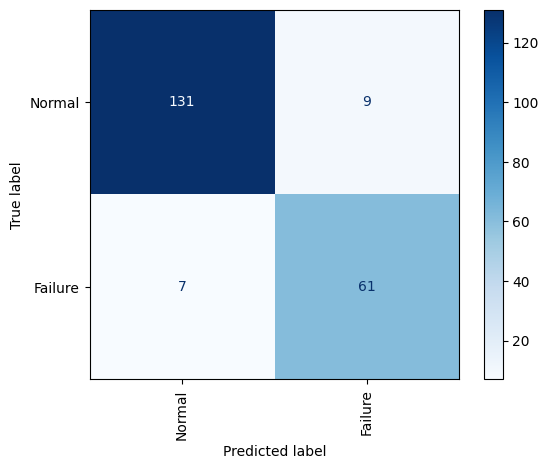

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay as cmd




rf_model = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
rf_model.fit(X_train, y_train)



labels = ['Normal', 'Failure']
cmd.from_estimator(rf_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [6]:
y_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9230769230769231
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       140
           1       0.87      0.90      0.88        68

    accuracy                           0.92       208
   macro avg       0.91      0.92      0.91       208
weighted avg       0.92      0.92      0.92       208



In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [75, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', None]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='recall')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


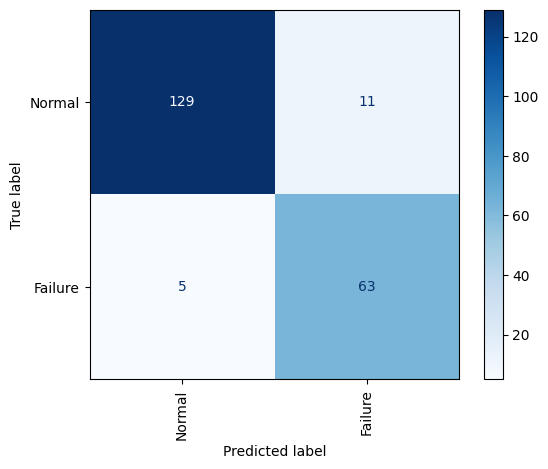

In [41]:
rf_model = RandomForestClassifier(max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, class_weight={0: 1, 1: 4}, random_state=42)
rf_model.fit(X_train, y_train)



labels = ['Normal', 'Failure']
cmd.from_estimator(rf_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [ ]:
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9230769230769231
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       140
           1       0.85      0.93      0.89        68

    accuracy                           0.92       208
   macro avg       0.91      0.92      0.91       208
weighted avg       0.93      0.92      0.92       208



Lets try with Logistic regression and see if that performs better

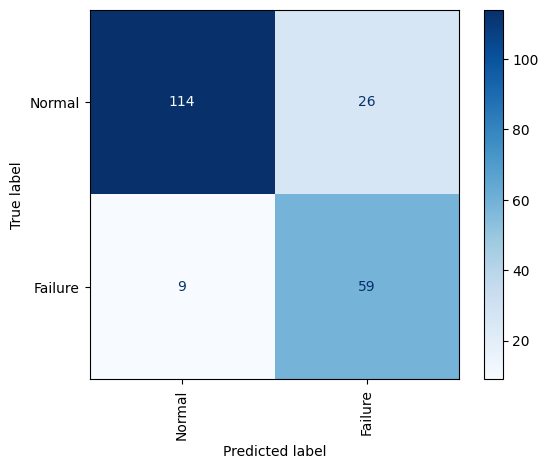

In [46]:
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=42, max_iter=100, class_weight={0: 1, 1: 3})
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [37]:
proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class


# Evaluate the model

Accuracy: 0.9230769230769231
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       140
           1       0.74      0.85      0.79        68

    accuracy                           0.86       208
   macro avg       0.83      0.86      0.84       208
weighted avg       0.86      0.86      0.86       208



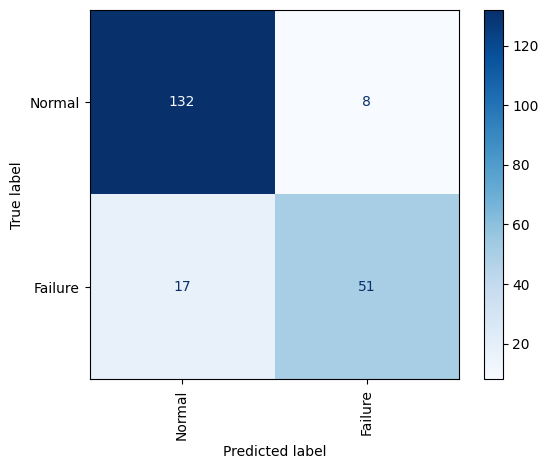

In [47]:
lr_model = LogisticRegression(random_state=42, max_iter=10000)
lr_model.fit(X_train, y_train)

cmd.from_estimator(lr_model, X_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')
# Evaluate the model

threshold = 0.3
predictions = (proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, predictions))